In [1]:
import gzip        
import pickle    
import numpy as np  
import matplotlib.pyplot as plt  
from sklearn.metrics import r2_score
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
from scipy.signal import find_peaks



In [2]:
def mesh_index_to_km(x):
    return (x / 899) * 110

def km_to_mesh_index(x):
    return (x / 110) * 899

In [3]:
def get_GL_index(gl_array):
    gl_array = np.array(gl_array).astype(int)
    for i in range(1, len(gl_array)):
        if gl_array[i-1] == 0 and gl_array[i] == 1:
            return i
    return None

# INPUT: TEST VARIABLE + TEST VALUE + FILEPATH

In [4]:
variable = "NoNoise nx = 900"
value = "10ka"

path = "/home/kayatroyer/Repositories/brinkmodeltest/Output/Variable_Dictionaries/DATA_Dictionary_2025_10_30__11_30_04.pkl.gz"
with gzip.open(path, 'rb') as f:
    DATA_dict = pickle.load(f)


In [5]:
title_GL_basic = "Grounding Line Evolution: " + variable + " " + value
xaxis_GL_basic = "Mesh Index"
yaxis_GL_basic = "Timestep (yrs)"

title_GL_better = "Grounding Line Evolution: " + variable + " " + value
xaxis_GL_better = "Time (yrs)"
yaxis_GL_better = "Grounding Line Position (km)"

title_GLandVel = "Velocity Comparison to Grounding Line Location: " + variable + " " + value
xaxis_vel = "Time (yrs)"
yaxis_vel  = "Velocity (m/yr)"

title_SMB = "Glacier Surface: Accumulation/Ablation " +  variable + " " + value
xaxis_SMB = "Maximum Accumulation to Maximum Ablation (m/yr)"
yaxis_SMB = "Ice Surface Elevation (m)"

title_H = "Ice Thickness Behind Terminus: " +  variable + " " + value
xaxis_H = "Time (yrs)"
yaxis_H = ""

title_bed = "Bedrock Erosion Evolution: " + variable + " " + value
xaxis_bed = "Distance (km)"
yaxis_bed = "Bed Elevation (m)"

print(title_GL_basic)

Grounding Line Evolution: NoNoise nx = 900 10ka


## OPENING INDIVIDUAL DICTIONARIES

In [6]:
bed_dict = DATA_dict['bed_dict']
base_dict = DATA_dict['base_dict']
surf_dict = DATA_dict['surf_dict']
sed_dict = DATA_dict['sed_dict']
H_dict = DATA_dict['H_dict']
us_dict = DATA_dict['us_dict']
ub_dict = DATA_dict['ub_dict']
Hs_dict = DATA_dict['Hs_dict']
GL_dict = DATA_dict['GL_dict']
Qs_dict = DATA_dict['Qs_dict']
SMB_dict = DATA_dict['SMB_dict']
counter_dict = DATA_dict['counter_dict']
final_time = list(GL_dict)[-1]
print(final_time)


12950.549598235726


In [7]:
time = np.array(list(us_dict.keys()))
mesh_indices = np.arange(len(us_dict[time[0]]))
data_matrix = np.array([us_dict[t] for t in time])

threshold = 0.05  # meters, or whatever your model units are
gl_positions = []

for t in time:
    us = np.array(us_dict[t])
    ub = np.array(ub_dict[t])
    
    # Find where |us - ub| < tol
    diff = np.abs(us - ub)
    equal_points = np.where(diff < threshold)[0]

    if len(equal_points) == 0:
        gl_positions.append(np.nan)
        continue

    # The grounding line = first point where they are equal moving downstream
    gl_positions.append(equal_points[0])
    
GL_km = mesh_index_to_km(np.array(gl_positions))

peaks, _   = find_peaks(GL_km, prominence=5)
troughs, _ = find_peaks(-GL_km, prominence=5)

periods    = np.diff(np.array(time)[peaks])
adv_dists  = GL_km[peaks]
ret_dists  = GL_km[troughs]

In [8]:
# path2 = "/home/kayatroyer/Repositories/brinkmodeltest/Output/Variable_Dictionaries/DATA_Dictionary_2025_09_24__16_28_09.pkl.gz"
# with gzip.open(path2, 'rb') as f:
#     DATA_dict2 = pickle.load(f)

# bed_dict2 = DATA_dict2['bed_dict']
# base_dict2 = DATA_dict2['base_dict']
# surf_dict2 = DATA_dict2['surf_dict']
# sed_dict2 = DATA_dict2['sed_dict']
# H_dict2 = DATA_dict2['H_dict']
# us_dict2 = DATA_dict2['us_dict']
# ub_dict2 = DATA_dict2['ub_dict']
# Hs_dict2 = DATA_dict2['Hs_dict']
# GL_dict2 = DATA_dict2['GL_dict']
# Qs_dict2 = DATA_dict2['Qs_dict']
# # SMB_dict = DATA_dict['SMB_dict']
# counter_dict2 = DATA_dict2['counter_dict']
# final_time2 = list(GL_dict2)[-1]
# print(final_time2)

In [9]:
# time2 = list(GL_dict2.keys())
# mesh_indices2 = np.arange(len(GL_dict2[time2[0]]))
# data_matrix2 = np.array([GL_dict2[t] for t in time2])
# gl_positions2 = [np.argmax(row > 0.5) for row in data_matrix2]
# GL_km2 = mesh_index_to_km(np.array(gl_positions2))
# peaks2, _   = find_peaks(GL_km2, prominence=5)
# troughs2, _ = find_peaks(-GL_km2, prominence=5)

# periods2    = np.diff(np.array(time2)[peaks2])
# adv_dists2  = GL_km2[peaks2]
# ret_dists2  = GL_km2[troughs2]

## BETTER GL PLOT

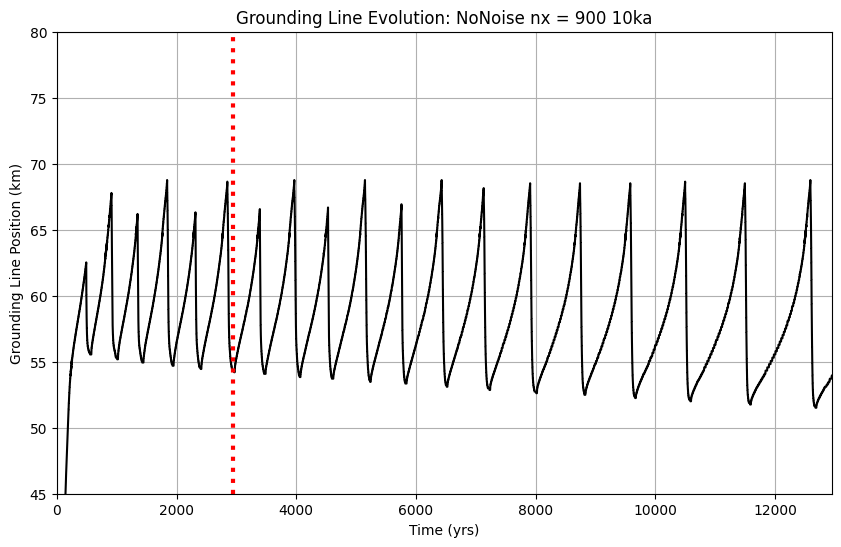

Mean cycle period: 599.34 years
[4.85584072e+02 4.21654343e+02 4.36371841e+02 4.94334407e+02
 4.72895014e+02 5.33207798e+02 5.43033325e+02 5.75911381e+02
 5.63402671e+02 6.17565622e+02 6.09986524e+02 7.89105596e-01
 6.70830840e+02 7.01924615e+02 7.75807109e+02 8.33615793e+02
 8.40038336e+02 9.16654562e+02 9.98130561e+02 6.52194786e-01
 1.09381158e+03]
Mean advance amplitude: 66.05 km
[31.32369299 62.52502781 67.78642937 66.19577308 68.76529477 66.31813126
 68.6429366  66.56284761 68.76529477 66.68520578 68.76529477 66.92992214
 66.92992214 68.76529477 68.15350389 68.52057842 68.52057842 68.52057842
 68.6429366  68.52057842 68.52057842 68.76529477]
Mean retreat amplitude: 50.77 km
[ 0.         55.55061179 55.18353726 54.93882091 54.69410456 54.44938821
 54.20467186 54.08231368 53.83759733 53.71523915 53.4705228  53.34816463
 53.10344828 52.85873192 52.61401557 52.4916574  52.24694105 52.00222469
 51.75750834]


In [25]:
fig, ax = plt.subplots(figsize=(10,6))

plt.plot(time, GL_km, color = 'black', label = 'Basic GL - NO NOISE')
# plt.plot(time2, GL_km2, color = 'red', label = 'OG run (9/24 16:28)', alpha = 0.5)
# plt.plot(np.array(time)[peaks], GL_km[peaks], 'go', label='Extended State')
# plt.plot(np.array(time)[troughs], GL_km[troughs], 'ro', label='Retracted State')
# plt.text(0.1, 0.15, f'Avg period: {np.mean(periods):.2f} years', transform=plt.gca().transAxes)

# plt.axvline(x=2865, color = 'red', label = 'Retreat (t=2865)')
plt.axvline(x=2950, color = 'red', ls = ':', linewidth=3, label = 'Retracted (t=2950)')
# plt.axvline(x=3200, color = 'black', ls = '-.', label = 'Advancing (t=3200)')
# plt.axvline(x=3375, color = 'black', ls = '--', label = ' Extended (t=3375)')


# plt.legend(loc = 4)
plt.xlim(0,12950)
plt.ylim(45,80)
plt.xlabel(xaxis_GL_better)
plt.ylabel(yaxis_GL_better)
plt.title(title_GL_better )
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(periods):.2f} years")
print(periods)

print(f"Mean advance amplitude: {np.mean(adv_dists):.2f} km")
print(adv_dists)

print(f"Mean retreat amplitude: {np.mean(ret_dists):.2f} km")
print(ret_dists)



### Pulling Velocity Data

In [11]:
term_surface_velocity = []
term_basal_velocity = []

for t in sorted(us_dict.keys()): 
    us_ = us_dict[t]
    ub_ = ub_dict[t]

    notNAN = np.where(np.isfinite(us_))[0]

    if len(notNAN) > 0:
        terminus = notNAN[-1]
    else:
        terminus = None

    if terminus is not None and terminus >= 75:
        term_usvel = us_[terminus - 75]
        term_ubvel = ub_[terminus - 75]
    else:
        term_usvel = 0
        term_ubvel = 0

    if np.isnan(term_usvel):
        term_usvel = 0
    if np.isnan(term_ubvel):
        term_ubvel = 0

    term_surface_velocity.append(term_usvel)
    term_basal_velocity.append(term_ubvel)

## VELOCITY OVER GL PLOT

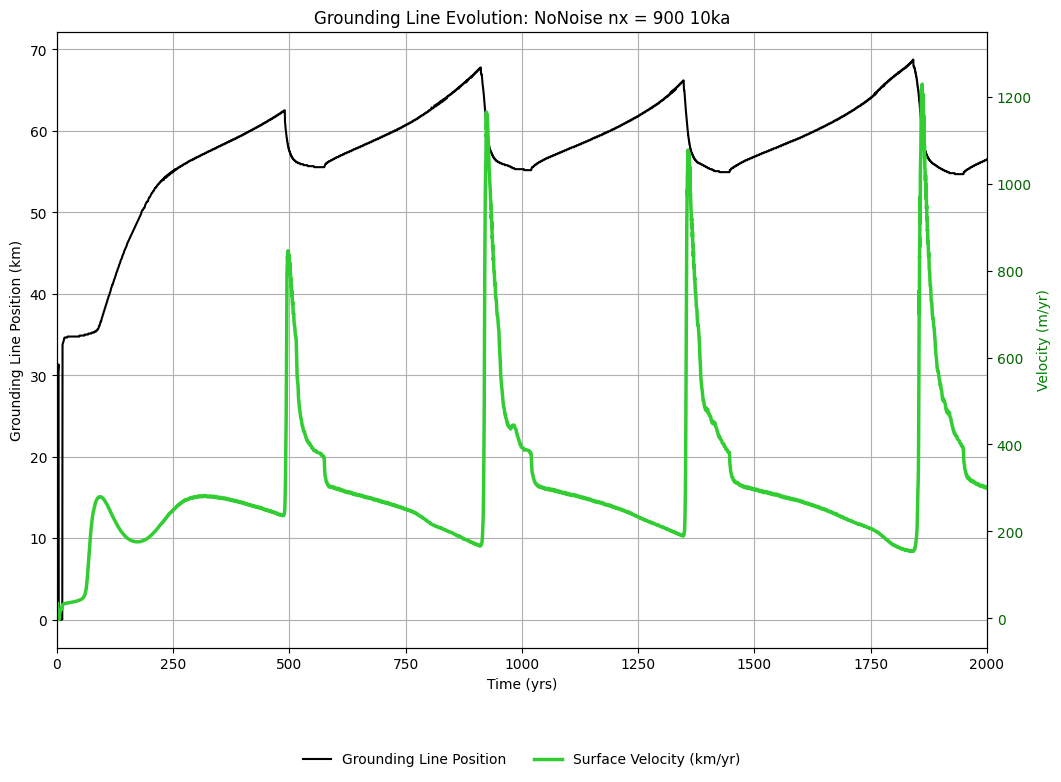

In [12]:
fig, ax1 = plt.subplots(figsize=(12, 8))

# GL position
ax1.plot(time, GL_km, label='Grounding Line Position', color='black')
ax1.set_xlabel(xaxis_vel)
ax1.set_ylabel(yaxis_GL_better, color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid()

# Velocity
ax2 = ax1.twinx()
ax2.plot(time, term_surface_velocity, 'limegreen', ls = '-', label='Surface Velocity (km/yr)', linewidth = 2.5)
# ax2.plot(time, term_basal_velocity, 'm-.', label='Basal Velocity (km/yr)',  linewidth = 2.5)
ax2.set_ylabel(yaxis_vel, color='green')
ax2.tick_params(axis='y', labelcolor='darkgreen')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.set_xlim(0,2000)
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
plt.title(title_GL_better )

# plt.title(title_GLandVel)
plt.show()
# fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/FinalFigures/40k_default_all.svg", format ="svg", bbox_inches='tight')



## BED ELEVATION CHANGE PLOT

In [13]:
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# num_points = len(next(iter(bed_dict.values())))
# x_km = mesh_index_to_km(np.arange(num_points))
# time = list(bed_dict.keys())
# # bed_profile = bed_dict[timesteps[0]] 
# norm = plt.Normalize(min(time), max(time))
# cmap = cm.jet

# fig, ax1 = plt.subplots(figsize=(14,5))

# for i, t in enumerate(time):
#     if i % 1000 != 0:  
#         continue

#     bed = bed_dict[t]
#     color = cmap(norm(t))
#     plt.plot(x_km, bed, color=color, label=f't={t:.1f}' if i % 25 == 0 else "")

# plt.xlabel(xaxis_bed)
# plt.ylabel(yaxis_bed)
# # plt.title(title_bed)
# # plt.gca().invert_xaxis() 
# # plt.legend(loc="upper right", fontsize=7)
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# plt.xlim(25,70)
# plt.ylim(-400,400)
# plt.colorbar()
# # plt.axvline(x=0, color='gray', linestyle='--', linewidth=2)

# plt.tight_layout()
# plt.show()
# # fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/FinalFigures/BedEvo_Ref_plot_40k_default.svg", format ="svg", bbox_inches='tight')


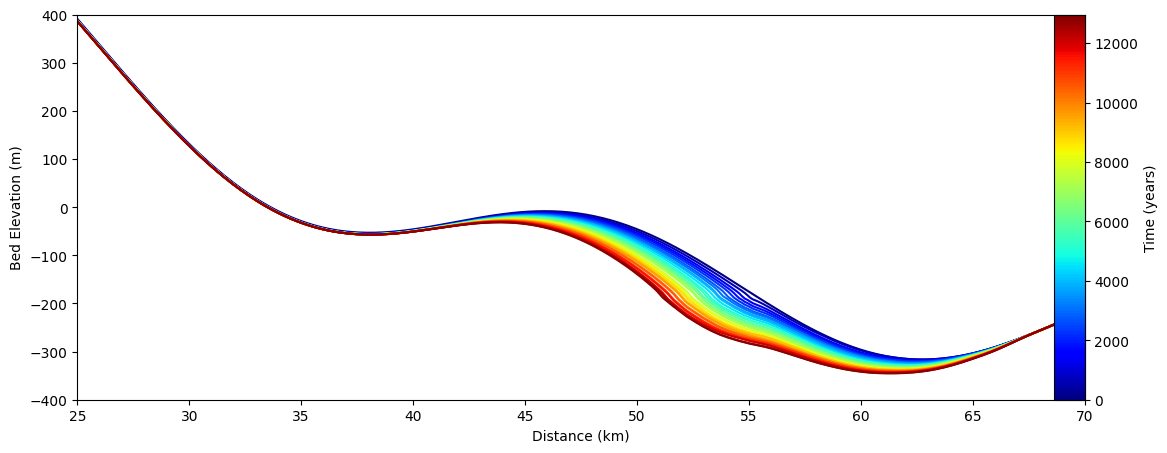

In [14]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import matplotlib.cm as cm

num_points = len(next(iter(bed_dict.values())))
x_km = mesh_index_to_km(np.arange(num_points))
time = list(bed_dict.keys())
norm = plt.Normalize(min(time), max(time))
cmap = cm.jet

fig, ax1 = plt.subplots(figsize=(13,5))

for i, t in enumerate(time):
    if i % 1000 != 0:  
        continue
    bed = bed_dict[t]
    color = cmap(norm(t))
    ax1.plot(x_km, bed, color=color, label=f't={t:.1f}' if i % 25 == 0 else "")

ax1.set_xlabel(xaxis_bed)
ax1.set_ylabel(yaxis_bed)
ax1.set_xlim(25, 70)
ax1.set_ylim(-400, 400)

# Make ScalarMappable for colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbaxes = inset_axes(ax1, width="3%", height="100%", loc='upper right',
                    bbox_to_anchor=(0, 0, 1, 1),
                    bbox_transform=ax1.transAxes, borderpad=0.01)

cbar = plt.colorbar(sm, cax=cbaxes)
cbar.set_label('Time (years)')
plt.show()


# fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/FinalFigures/BedEvo_plot_40k_default.svg", format ="svg")



## SMB PLOT

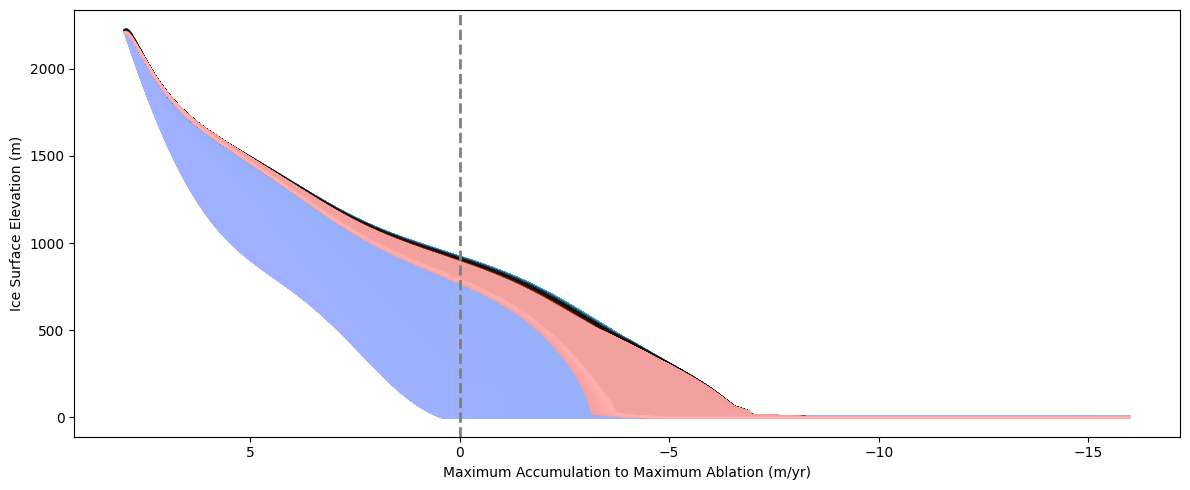

[ 7.98666667e+00  7.96000000e+00  7.93333333e+00  7.90666667e+00
  7.88000000e+00  7.85333333e+00  7.82666667e+00  7.80000000e+00
  7.77333333e+00  7.74666667e+00  7.72000000e+00  7.69333333e+00
  7.66666667e+00  7.64000000e+00  7.61333333e+00  7.58666667e+00
  7.56000000e+00  7.53333333e+00  7.50666667e+00  7.48000000e+00
  7.45333333e+00  7.42666667e+00  7.40000000e+00  7.37333333e+00
  7.34666667e+00  7.32000000e+00  7.29333333e+00  7.26666667e+00
  7.24000000e+00  7.21333333e+00  7.18666667e+00  7.16000000e+00
  7.13333333e+00  7.10666667e+00  7.08000000e+00  7.05333333e+00
  7.02666667e+00  7.00000000e+00  6.97333333e+00  6.94666667e+00
  6.92000000e+00  6.89333333e+00  6.86666667e+00  6.84000000e+00
  6.81333333e+00  6.78666667e+00  6.76000000e+00  6.73333333e+00
  6.70666667e+00  6.68000000e+00  6.65333333e+00  6.62666667e+00
  6.60000000e+00  6.57333333e+00  6.54666667e+00  6.52000000e+00
  6.49333333e+00  6.46666667e+00  6.44000000e+00  6.41333333e+00
  6.38666667e+00  6.36000

In [15]:
timesteps = sorted(SMB_dict.keys())
smb_profile = SMB_dict[timesteps[0]] 
cmap = cm.berlin

fig,ax  = plt.subplots(figsize=(12,5))


counts = sorted(counter_dict.values())  # all loop counts
sample_counts = counts[::1] 

# make a lookup: loop count → time
loop_to_time = {v: k for k, v in counter_dict.items()}

for j, c in enumerate(sample_counts):
    t = loop_to_time[c]
    surf = surf_dict[t]
    color = cmap(norm(t))
    label = f't={t:.1f}' if j % 5 == 0 else ""
    plt.plot(smb_profile, surf, color=color, label=label)


plt.xlabel(xaxis_SMB)
plt.ylabel(yaxis_SMB)
# plt.title(title_SMB)
plt.gca().invert_xaxis()
# plt.legend(loc="best", fontsize=8)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# plt.colorbar(sm, label='Time (years)', ax=plt.gca())
plt.axvline(x=0, color='gray', linestyle='--', linewidth=2)
plt.tight_layout()
plt.show()
# fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/FinalFigures/SMB_plot_40k_default.svg", format ="svg", bbox_inches='tight')

final_smb = list(SMB_dict.values())[-1]
print(final_smb)

## Plotting Thickness

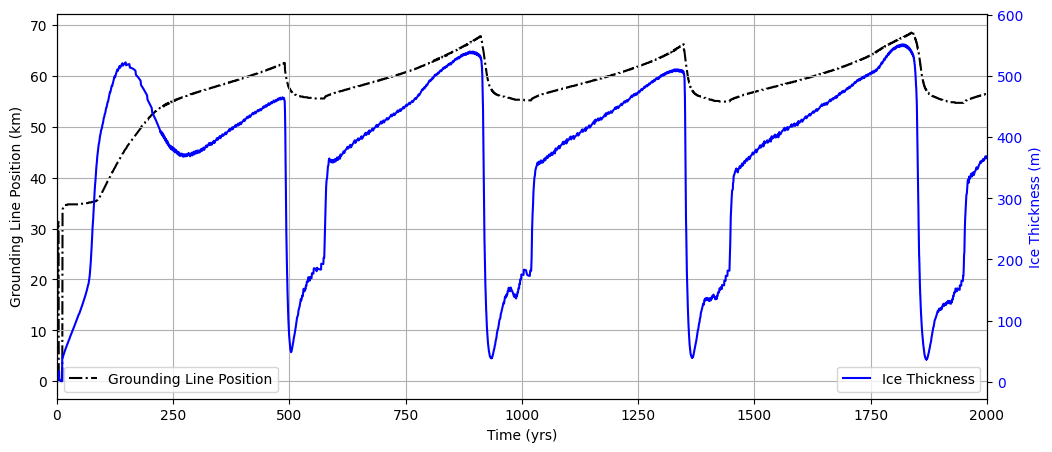

Thickness Max: []
GL Max: [  710  1394  2156  3257  4236  5310  6579  7772  9075 10343 11736 11742
 13078 14679 16377 18152 19795]


In [16]:
term_thinning = []
dist_behind_terminus = 50
mask = np.array(time) <= 10000
time_steps = sorted(H_dict.keys())
timesteps = np.array(time)[mask]



for t in time_steps:
    H_ = H_dict[t]

    terminus_indices = np.where(H_ > 1.0)[0]

    if len(terminus_indices) == 0:
        term_thinning.append(np.nan)
        continue

    terminus = terminus_indices[-1]

    if terminus >= dist_behind_terminus:
        term_H = H_[terminus - dist_behind_terminus]
    else:
        term_H = np.nan

    term_thinning.append(term_H)

peaks_gl, _ = find_peaks(GL_km, prominence=6, height=60) 
peaks_gl = np.array(peaks_gl)[mask[peaks_gl]]

peaks_H, _ = find_peaks(term_thinning, prominence=10, height = 600, distance = 500)     
peaks_H = np.array(peaks_H)[mask[peaks_H]]


fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.set_zorder(2)
ax1.patch.set_visible(False)


ax1.plot(time, GL_km, label='Grounding Line Position', ls = 'dashdot', color='black', zorder=1)
# ax1.plot(np.array(time)[peaks_gl], GL_km[peaks_gl], 'ro', label='Maximum Advance', markersize = 10, zorder=10)
ax1.set_xlabel(xaxis_vel)
ax1.set_ylabel(yaxis_GL_better, color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xlim(0,2000)
ax1.grid()

# Secondary axis for velocities
ax2 = ax1.twinx()
ax2.plot(time_steps, term_thinning, color='blue', linestyle='-', label=f'Ice Thickness', zorder=1)
# ax2.plot(np.array(time_steps)[peaks_H], np.array(term_thinning)[peaks_H], 'go', label='Thickness Peaks', markersize = 10, zorder=10)
ax2.set_ylabel(("Ice Thickness (m)"), color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax2.legend(loc = 4)
ax1.legend(loc = 3)

# plt.title(title_H)
plt.show()

# fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/FinalFigures/IceThickness_plot_40k_default.svg", format ="svg", bbox_inches='tight')

print(f"Thickness Max: {peaks_H[1:]}")
print(f"GL Max: {peaks_gl}")
# print(peaks_H[1:] - peaks_gl) 

Text(0.5, 1.0, 'Sediment Discharge VS GL: NoNoise nx = 900 10ka')

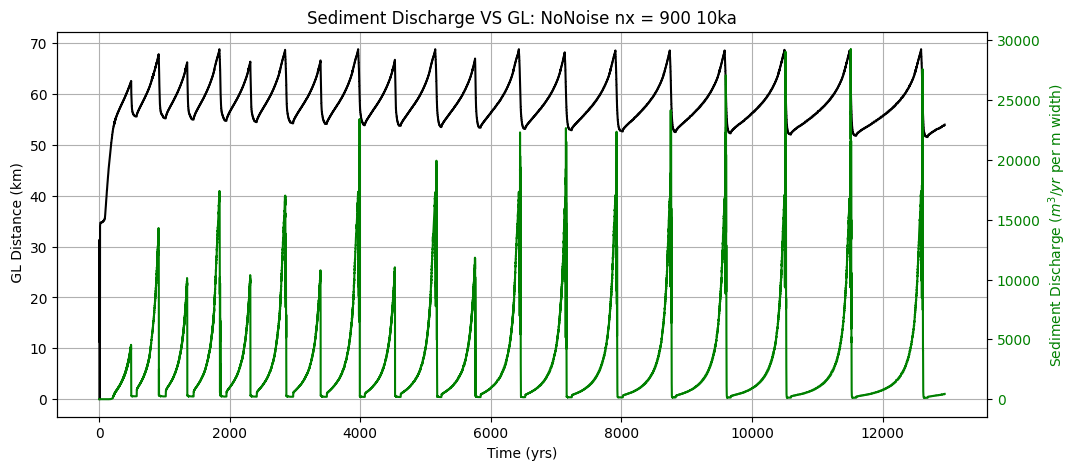

In [17]:
max_Qs = np.array([max(values) for values in Qs_dict.values()])
time = np.array(list(Qs_dict.keys()))


fig, ax1 = plt.subplots(figsize=(12, 5))

# GL position
ax1.plot(time, GL_km, label='Grounding Line Position', color='black')
ax1.set_xlabel("Time (yrs)")
ax1.set_ylabel(f" GL Distance (km)", color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid()

# Sediment Discharge 
ax2 = ax1.twinx()
ax2.plot(time, max_Qs, 'green', ls = '-')
ax2.set_ylabel("Sediment Discharge ($m^3/yr$ per m width)", color='green')
ax2.tick_params(axis='y', labelcolor='green')
# ax1.set_xlim(1400,1750)
# ax2.set_ylim(0,2000)
plt.title(f"Sediment Discharge VS GL: {variable} {value}")

## Velocity VS Thickness


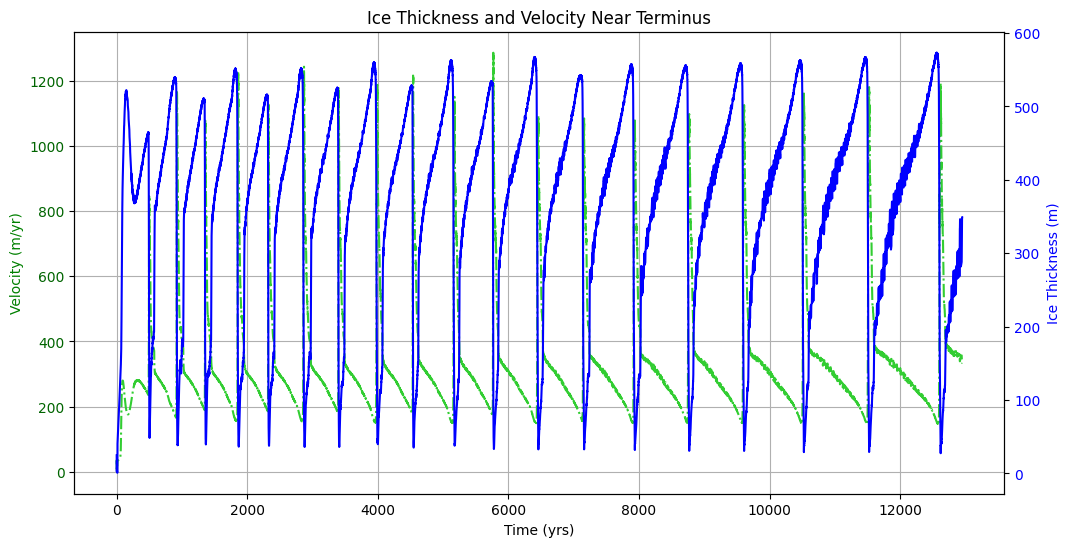

In [18]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(time, term_surface_velocity, 'limegreen', ls = '-.', label='Surface Velocity (km/yr)')
ax1.set_xlabel(xaxis_vel)
ax1.set_ylabel(yaxis_vel, color='green')
ax1.tick_params(axis='y', labelcolor='darkgreen')
# ax1.set_xlim(0,10000)
ax1.grid()


ax2 = ax1.twinx()
ax2.plot(time_steps, term_thinning, color='blue', linestyle='-', label=f'Thickness {dist_behind_terminus} nodes behind terminus')
ax2.set_ylabel(("Ice Thickness (m)"), color='blue')
ax2.tick_params(axis='y', labelcolor='blue')


plt.title("Ice Thickness and Velocity Near Terminus")
plt.show()


In [19]:
vel_peaks, _ = find_peaks(term_surface_velocity, prominence=5) 
H_peaks, _ = find_peaks(term_thinning, prominence=5)     

Text(0, 0.5, 'Near Terminus Surface Velocity')

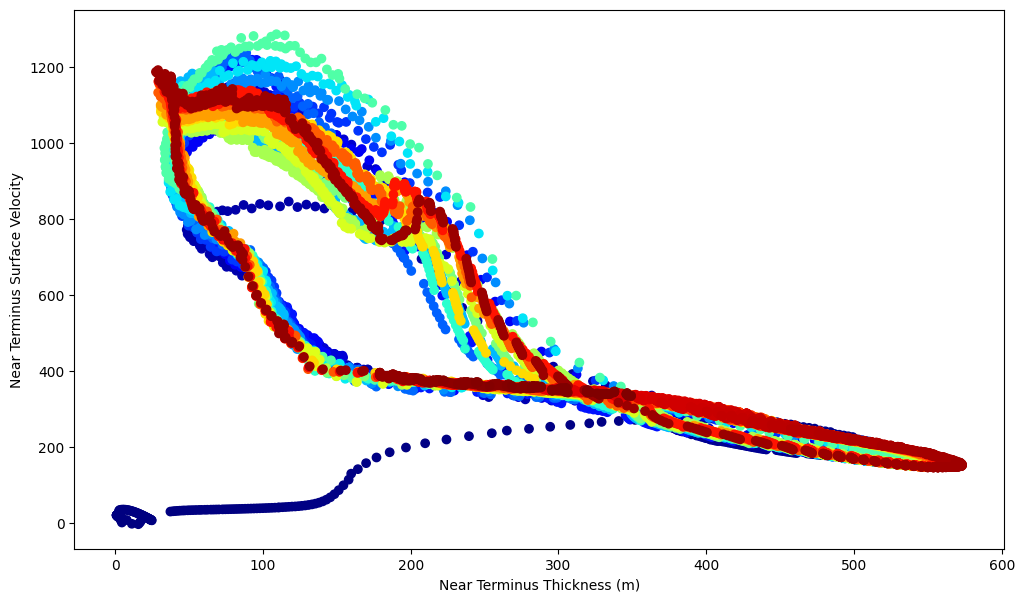

In [20]:
fig,ax = plt.subplots(figsize = (12,7))
plt.scatter(term_thinning, term_surface_velocity, c = time, cmap = 'jet')
plt.xlabel("Near Terminus Thickness (m)")
plt.ylabel("Near Terminus Surface Velocity")

In [21]:
print(np.size(vel_peaks))
print(np.size(H_peaks))

1057
449
